In [1]:
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

env: THEANO_FLAGS=device=cpu,floatX=float64


# fetch data

In [2]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.156s.
Extracting tf features for LDA...
done in 1.586s.


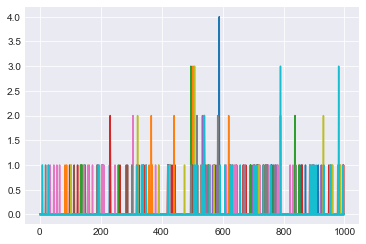

In [3]:

plt.plot(tf[:10, :].toarray().T);

# Construct model

The model we construct should follow the form of:

- $\theta_{1:D} \sim \text{Dir}(\alpha) \in \mathbb{R}^{K}$
- $z_{1:D, 1:N_d} \sim \text{Cat}(\theta) \in \{1, \cdots, K\}$
- $\beta_{1:K} \sim \text{Dir}(\eta) \in \mathbb{R}^{V}$
- $w_{1:D, 1:N_d} \sim \text{Cat}(\beta_{z_{1:D, 1:N_d}})\in \{1, \cdots, V\}$






For a document d consisting of tokens w, the log-likelihood of the LDA model with K topics is given as
\begin{align}
    \log p\left(d|\theta_{d},\beta\right) & = & \sum_{w\in d}\log\left[\sum_{k=1}^{K}\exp\left(\log\theta_{d,k} + \log \beta_{k,w}\right)\right]+const,
\end{align}
where $\theta_d$ is the topic distribution for document $d$ and $\beta$ is the word distribution for the $K$ topics. We define a function that returns a tensor of the log-likelihood of documents given $\theta_d$ and $\beta$.

\begin{align}
    \log p(d_j|\theta_j, \beta) &= \log p (w_{j,1:N_d}|\theta_j, \beta)\\
                 &= \log \prod_i^{N_d} p (w_{j, i} |\theta_j, \beta)\\
                 &= \sum_i^{N_d}  \log \left[\sum_k^K p (w_{j,i} |z_{j, i}=k, \beta_{i, k})p(z_{j, i}=k|\theta_j) \right]\\
                 &= \sum_i^{N_d}  \log \left[\sum_k^K \prod_k^K\beta_{i, k}^{[w_{j,i}=k]}\prod_k^K\theta_{j, k}^{[z_{j,i}=k]}\right]\\
                 &= \sum_i^{N_d}  \log \left[\sum_k^K \beta_{i, k}\theta_{j, k}\right]
\end{align}

In [4]:
def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
#         ll_docs = vfreqs * pmmath.log(pmmath.sum(theta[dixs] * beta.T[vixs], axis=1)).ravel()


        
        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens

    return ll_docs_f

In [5]:

n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480263
Sparsity = 0.0253936


## Model construction


In [6]:
n_topics = 10
# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 500

# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=n_samples_tr)
    beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

/anaconda3/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

In [7]:
# with model:
#     step = pm.Metropolis()
#     trace = pm.sample(5000, step=[step])

# AEVB


In [8]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [9]:

encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [10]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

In [11]:
eta = .1
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t: doc_t_minibatch})

  0%|          | 0/10000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.8571e+06: 100%|██████████| 10000/10000 [05:00<00:00, 33.32it/s]
Finished [100%]: Average Loss = 2.8576e+06


Approximation{MeanFieldGroup[None, 9] & MeanFieldGroup[9990]}


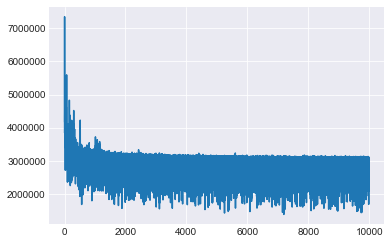

In [12]:
print(approx)
plt.plot(approx.hist[10:]);

## Print out the results

In [13]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: people god think don just know said say time like
Topic #1: use windows drive card file does like using problem know
Topic #2: edu com mail ftp send available graphics pub information list
Topic #3: just like don know good think car time ve people
Topic #4: db 00 10 25 17 11 15 16 20 12
Topic #5: ax max g9v b8f a86 pl 145 giz 1d9 bhj
Topic #6: game team year games season hockey play good players think
Topic #7: space new 1993 research april 000 program 10 university gun
Topic #8: key encryption chip use clipper government keys law security public
Topic #9: use water ground wire insurance don like power used does


In [12]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: people god think don just know said say time like
Topic #1: use windows drive card file does like using problem know
Topic #2: edu com mail ftp send available graphics pub information list
Topic #3: just like don know good think car time ve people
Topic #4: db 00 10 25 17 11 15 16 20 12
Topic #5: ax max g9v b8f a86 pl 145 giz 1d9 bhj
Topic #6: game team year games season hockey play good players think
Topic #7: space new 1993 research april 000 program 10 university gun
Topic #8: key encryption chip use clipper government keys law security public
Topic #9: use water ground wire insurance don like power used does
